# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import joblib

import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling as ResamplingEnum # Уточнение Resampling
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely import wkt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from torch import nn
from torch import optim
import torch
from tqdm import tqdm

from sklearn.metrics import accuracy_score, recall_score, f1_score, auc, RocCurveDisplay, roc_curve, roc_auc_score

# Импорт данных

In [2]:
etalons_df = pd.read_csv('../etalons_with_cluster.csv', encoding='UTF-8')
etalons_df['geometry'] = etalons_df['geometry'].apply(wkt.loads)
etalons = gpd.GeoDataFrame(etalons_df, geometry='geometry', crs='EPSG:4326')

In [98]:
# Импортируем фото для каждого ареала
X = []
for i, row in etalons.iterrows():
    try:
        with rasterio.open(f'../cropped/crop_{row["index"]}.tif') as src:
            data = src.read(1)
            X.append(data)
    except Exception as e:
        print(e)


# Приводим все фото к одной размерности с помощью padding
max_rows = max(arr.shape[0] for arr in X)
max_cols = max(arr.shape[1] for arr in X)

padded_arrays = []
for arr in X:
    pad_rows = max_rows - arr.shape[0]
    pad_cols = max_cols - arr.shape[1]

    padded_arr = np.pad(arr,
          pad_width=((0, pad_rows), (0, pad_cols))).flatten()
    padded_arrays.append(padded_arr)

X = np.stack(padded_arrays)

###

# 1. Классификация типов лесов - выделение основных ареалов леса


Исходя от доли лесов, полученных в предыдущем модуле, формируем целевую переменную. 

Три основных ареала леса:
- Ареал1: не покрыт лесами,
- Ареал2: преимущественно хвойный лес,
- Ареал3: преимущественно лиственный лес. 

In [99]:
target = etalons.apply(lambda row: 3 if row['avg_leaves'] > row['avg_conifer'] and row['avg_leaves'] > row['avg_without_trees']\
              else (2 if row['avg_conifer'] > row['avg_without_trees'] else 1), axis=1)

target.head(3)

0    1
1    3
2    1
dtype: int64

Подготовим выборки для обучения, валидации, тестирования в такой пропрорции: 70% для обучения, 15% для валидации, 15% для тестирования.

Данная пропорция обеспечит качественное обучение модели, а также объективную оценку модели на валидации и тестирование.

In [100]:
# Берем 70% для обучения
X_train, X_temp, y_train, y_temp = train_test_split(X, target, train_size=0.7, random_state=1)

# Остальные 30% делим между валидацей и тестированием.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=1)

###

## Обучение моделей

Рассмотрим 3 алгоритма  для
многоклассовой классификации:
- **KNeighborsClassifier** - алгоритм классификации, основанный на гипотезе компактности, которая предполагает, что расположенные близко друг к другу объекты в пространстве признаков имеют схожие значения целевой переменной или принадлежат к одному классу.
- **CatboostClassifier** - алгоритм машинного обучения, разработанный компанией Яндекс.
- **RandomForestClassifier** -  универсальный алгоритм машинного обучения, суть которого состоит в использовании ансамбля решающих деревьев. Само по себе решающее дерево предоставляет крайне невысокое качество классификации, но из-за большого их количества результат значительно улучшается. Также это один из немногих алгоритмов, который можно использовать в абсолютном большинстве задач.


Также обучим полносвязную и сверточную нейронную сеть для многоклассовой классификации.


Для оценки качества моделей используем следующие метрики: *PRECISION, RECALL, F1*.


### KNeighborsClassifier

In [101]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_val)
knn_proba = model_knn.predict_proba(X_val)

#### Метрики

In [102]:
# accuracy
print(f'Метрика accuracy для данной модели составляет {accuracy_score(y_val, y_pred):.3f}')

# recall
print(f'Метрика recall для данной модели составляет {recall_score(y_val, y_pred, average="weighted"):.3f}')

# f1
print(f'Метрика f1 для данной модели составляет {f1_score(y_val, y_pred, average="weighted"):.3f}')

Метрика accuracy для данной модели составляет 0.678
Метрика recall для данной модели составляет 0.678
Метрика f1 для данной модели составляет 0.675


### CatboostClassifier

In [103]:
model_catboost = CatBoostClassifier(n_estimators=100, verbose=50)
model_catboost.fit(X_train, y_train)
y_pred = model_catboost.predict(X_val)
catboost_proba = model_catboost.predict_proba(X_val)

Learning rate set to 0.5
0:	learn: 0.9367188	total: 468ms	remaining: 46.4s
50:	learn: 0.4435800	total: 12.7s	remaining: 12.2s
99:	learn: 0.3051087	total: 24.6s	remaining: 0us


#### Метрики

In [104]:
# accuracy
print(f'Метрика accuracy для данной модели составляет {accuracy_score(y_val, y_pred):.3f}')

# recall
print(f'Метрика recall для данной модели составляет {recall_score(y_val, y_pred, average="weighted"):.3f}')

# f1
print(f'Метрика f1 для данной модели составляет {f1_score(y_val, y_pred, average="weighted"):.3f}')

Метрика accuracy для данной модели составляет 0.727
Метрика recall для данной модели составляет 0.727
Метрика f1 для данной модели составляет 0.722


### RandomForestClassifier

In [105]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_val)
rf_proba = model_rf.predict_proba(X_val)

#### Метрики

In [106]:
# accuracy
print(f'Метрика accuracy для данной модели составляет {accuracy_score(y_val, y_pred):.3f}')

# recall
print(f'Метрика recall для данной модели составляет {recall_score(y_val, y_pred, average="weighted"):.3f}')

# f1
print(f'Метрика f1 для данной модели составляет {f1_score(y_val, y_pred, average="weighted"):.3f}')

Метрика accuracy для данной модели составляет 0.749
Метрика recall для данной модели составляет 0.749
Метрика f1 для данной модели составляет 0.743


####

### Полносвязная нейронная сеть

#### Инициализация сети

In [108]:
class ForestNN(nn.Module):
  def __init__(self, input_size, inner_size, n_classes=3):
    super().__init__()
    self.fc1 = nn.Linear(input_size, inner_size)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(inner_size, n_classes)
  def forward(self, x):
    x = self.relu1(self.fc1(x))
    x = self.fc2(x)

    return x

model_dnn = ForestNN(17250, 512, 3)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), weight_decay=0.001)

#### Обучение модели

In [109]:
epochs = 3
for epoch in range(epochs):
    tqdm_data = tqdm(X_train)
    for ind, img in enumerate(tqdm_data):
        target = y_train.iloc[ind]
        img = torch.tensor(img, dtype=torch.float32)
        
        outputs = model_dnn(img)

        loss = loss_func(outputs, torch.tensor(target-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)

100%|█████████████████████████████████████████████████████████████████████████████| 3248/3248 [00:18<00:00, 173.06it/s]


tensor(32.8899, grad_fn=<NllLossBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████| 3248/3248 [00:18<00:00, 173.73it/s]


tensor(32.8899, grad_fn=<NllLossBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████| 3248/3248 [00:18<00:00, 172.32it/s]

tensor(32.8899, grad_fn=<NllLossBackward0>)


#### Инференс нейронной сети

In [110]:
y_pred = []

model.eval()
dnn_proba = []
tqdm_data_val = tqdm(X_val)
for ind, img in enumerate(tqdm_data_val):
     target = y_train.iloc[ind]
     img = torch.tensor(img, dtype=torch.float32)
     outputs = model_dnn(img).argmax()
     y_pred.append(int(outputs + 1))
     dnn_proba.append(torch.sigmoid(outputs))

dnn_proba = np.array([out.detach().numpy() for out in cnn_proba])

100%|██████████████████████████████████████████████████████████████████████████████| 696/696 [00:00<00:00, 1705.76it/s]


#### Метрики

In [112]:
# accuracy
print(f'Метрика accuracy для данной модели составляет {accuracy_score(y_val, y_pred):.3f}')

# recall
print(f'Метрика recall для данной модели составляет {recall_score(y_val, y_pred, average="weighted"):.3f}')

# f1
print(f'Метрика f1 для данной модели составляет {f1_score(y_val, y_pred, average="weighted"):.3f}')

Метрика accuracy для данной модели составляет 0.329
Метрика recall для данной модели составляет 0.329
Метрика f1 для данной модели составляет 0.337


### 

### Сверточная нейронная сеть

#### Инициализация сети

In [127]:
class ForestСNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=3)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(3)

    self.conv2 = nn.Conv2d(in_channels=9, out_channels=27, kernel_size=3)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(3)

      
    self.fc1 = nn.Linear(4914, 256)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(256, 3)

      
  def forward(self, x):
    out = self.pool1(self.relu1(self.conv1(x)))
    out = self.pool2(self.relu2(self.conv2(out)))

    out = torch.flatten(out)
    
    out = self.relu3(self.fc1(out))
    out = self.fc2(out)

    return out

model_cnn = ForestСNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), weight_decay=0.001)

#### Обучение модели

In [120]:
# приведем данные к двуразмерному формату для корректной работы алгоритма

X_train = X_train.reshape((3248, 1, 138, 125))
X_test = X_test.reshape((697, 1, 138, 125))
X_val = X_val.reshape((696, 1, 138, 125))

In [129]:
epochs = 3
for epoch in range(epochs):
    tqdm_data = tqdm(X_train)
    for ind, img in enumerate(tqdm_data):
        target = y_train.iloc[ind]
        img = torch.tensor(img, dtype=torch.float32)
        
        outputs = model_cnn(img)

        loss = loss_func(outputs, torch.tensor(target-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'loss: {int(loss)}')

100%|█████████████████████████████████████████████████████████████████████████████| 3248/3248 [00:07<00:00, 425.24it/s]


loss: 19


100%|█████████████████████████████████████████████████████████████████████████████| 3248/3248 [00:07<00:00, 438.33it/s]


loss: 19


100%|█████████████████████████████████████████████████████████████████████████████| 3248/3248 [00:07<00:00, 433.47it/s]

loss: 19


#### Инференс нейронной сети

In [130]:
y_pred = []

cnn_proba = []
model.eval()
tqdm_data_val = tqdm(X_val)
for ind, img in enumerate(tqdm_data_val):
     target = y_train.iloc[ind]
     img = torch.tensor(img, dtype=torch.float32)
     outputs = model_cnn(img)
     y_pred.append(int(outputs.argmax() + 1))
     cnn_proba.append(torch.sigmoid(outputs))

cnn_proba = np.array([out.detach().numpy() for out in cnn_proba])

100%|██████████████████████████████████████████████████████████████████████████████| 696/696 [00:00<00:00, 1077.40it/s]


#### Метрики

In [131]:
# accuracy
print(f'Метрика accuracy для данной модели составляет {accuracy_score(y_val, y_pred):.3f}')

# recall
print(f'Метрика recall для данной модели составляет {recall_score(y_val, y_pred, average="weighted"):.3f}')

# f1
print(f'Метрика f1 для данной модели составляет {f1_score(y_val, y_pred, average="weighted"):.3f}')

Метрика accuracy для данной модели составляет 0.214
Метрика recall для данной модели составляет 0.214
Метрика f1 для данной модели составляет 0.186


Построим ROC-AUC кривые и сделаем выводы.

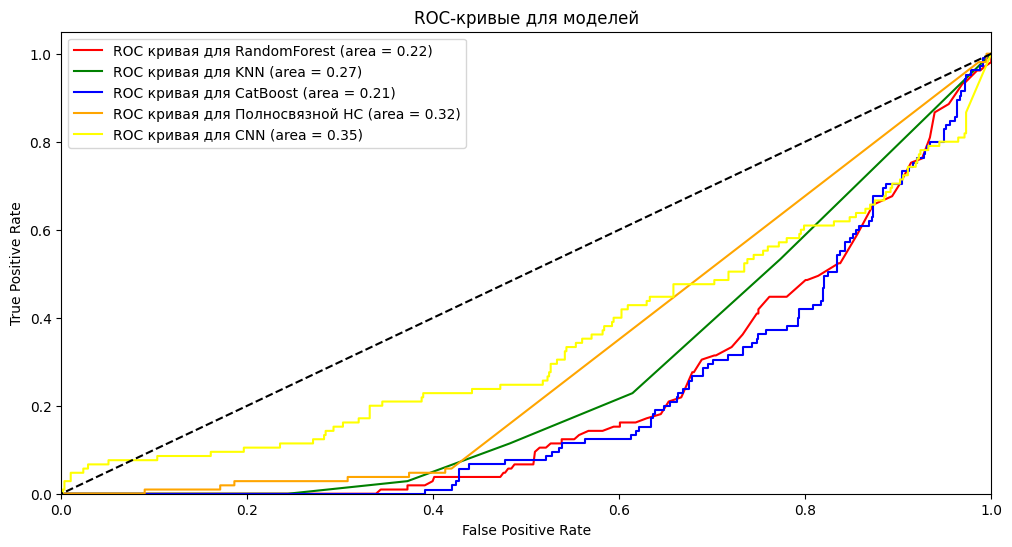

In [132]:
plt.figure(figsize=(12, 6))

y_val_binary = label_binarize(y_val, classes=[0, 1])

fpr, tpr, treshold = roc_curve(y_val_binary[:, 1], rf_proba[:, 1])
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='red',
         label=f'ROC кривая для RandomForest (area = {roc_auc:.2f})')


fpr, tpr, treshold = roc_curve(y_val_binary[:, 1], knn_proba[:, 1])
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='green',
         label=f'ROC кривая для KNN (area = {roc_auc:.2f})')

fpr, tpr, treshold = roc_curve(y_val_binary[:, 1], catboost_proba[:, 1])
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='blue',
         label=f'ROC кривая для CatBoost (area = {roc_auc:.2f})')


fpr, tpr, treshold = roc_curve(y_val_binary[:, 1], dnn_proba[:, 1])
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='orange',
         label=f'ROC кривая для Полносвязной НС (area = {roc_auc:.2f})')


fpr, tpr, treshold = roc_curve(y_val_binary[:, 1], cnn_proba[:, 1])
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='yellow',
         label=f'ROC кривая для CNN (area = {roc_auc:.2f})')

plt.plot([1, 0], [1, 0], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для моделей')
plt.legend(loc="upper left")
plt.show()

Отобразив ROC-прямые и вычислив AUC, делаем вывод, что CNN показал лучшее качество.

Но KNN уступает другим алгоритмам по всем остальным метрикам. В большинстве метрик <b>RandomForestClassifier</b> показал уверенное лидерство. 

Проведем оценку точности на валидационной и тестовой выборках для лучшей модели (RandomForestClassifier).

In [73]:
y_pred = model_rf.predict(X_val)
print('Метрики для валидационной выборке:')
print(f'Метрика accuracy для RandomForestClassifier составляет {accuracy_score(y_val, y_pred):.3f}')
print(f'Метрика recall для RandomForestClassifier составляет {recall_score(y_val, y_pred, average="weighted"):.3f}')
print(f'Метрика f1 для RandomForestClassifier составляет {f1_score(y_val, y_pred, average="weighted"):.3f}\n\n')

y_pred = model_rf.predict(X_test)
print('Метрики для тестовой выборке:')
print(f'Метрика accuracy для RandomForestClassifier составляет {accuracy_score(y_test, y_pred):.3f}')
print(f'Метрика recall для RandomForestClassifier составляет {recall_score(y_test, y_pred, average="weighted"):.3f}')
print(f'Метрика f1 для RandomForestClassifier составляет {f1_score(y_test, y_pred, average="weighted"):.3f}')

Метрики для валидационной выборке:
Метрика accuracy для RandomForestClassifier составляет 0.733
Метрика recall для RandomForestClassifier составляет 0.733
Метрика f1 для RandomForestClassifier составляет 0.726


Метрики для тестовой выборке:
Метрика accuracy для RandomForestClassifier составляет 0.722
Метрика recall для RandomForestClassifier составляет 0.722
Метрика f1 для RandomForestClassifier составляет 0.718


Качество модели нас не устраивает. Один из способов увеличения качества - проведем подбор и настройку гиперпараметров лучшей модели. 

In [83]:
params = {'n_estimators': [300, 500, 700],
         'max_depth': [3, 7, 11, None]}

grid = GridSearchCV(estimator=RandomForestClassifier(),
                   param_grid=params, cv=4, n_jobs=-1, verbose=100)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
grid.best_params_

Fitting 4 folds for each of 12 candidates, totalling 48 fits


{'max_depth': None, 'n_estimators': 700}

In [267]:
# Сохраним лучшую модель
joblib.dump(best_model, 'model.pkl')

['model.pkl']

Проведем финальную оценку точности разработанной модели

In [85]:
y_pred = best_model.predict(X_val)
print('Метрики для валидационной выборке:')
print(f'Метрика accuracy для RandomForestClassifier составляет {accuracy_score(y_val, y_pred):.3f}')
print(f'Метрика recall для RandomForestClassifier составляет {recall_score(y_val, y_pred, average="weighted"):.3f}')
print(f'Метрика f1 для RandomForestClassifier составляет {f1_score(y_val, y_pred, average="weighted"):.3f}\n\n')

y_pred = best_model.predict(X_test)
print('Метрики для тестовой выборке:')
print(f'Метрика accuracy для RandomForestClassifier составляет {accuracy_score(y_test, y_pred):.3f}')
print(f'Метрика recall для RandomForestClassifier составляет {recall_score(y_test, y_pred, average="weighted"):.3f}')
print(f'Метрика f1 для RandomForestClassifier составляет {f1_score(y_test, y_pred, average="weighted"):.3f}')

Метрики для валидационной выборке:
Метрика accuracy для RandomForestClassifier составляет 0.749
Метрика recall для RandomForestClassifier составляет 0.749
Метрика f1 для RandomForestClassifier составляет 0.742


Метрики для тестовой выборке:
Метрика accuracy для RandomForestClassifier составляет 0.730
Метрика recall для RandomForestClassifier составляет 0.730
Метрика f1 для RandomForestClassifier составляет 0.725


Подбор гиперпараметров для модели позволил немного увеличить качество для RandomForestClassifier. 

Реализуем алгоритм вывода уверенности модели (вероятность правильности определения ареала). 

In [96]:
best_model.predict_proba([X_test[1]])

array([[0.        , 0.99571429, 0.00428571]])

Уверенность модели для Ареала 1 (не покрыт лесами) - 0% <br>
Уверенность модели для Ареала 2 (преимущественно хвойный лес) - ~99,6% <br>
Уверенность модели для Ареала 3 (преимущественно лиственный лес) - ~0.0004% <br>

Визуализируем результат разделения на ареалы на карте участка для RandomForest.

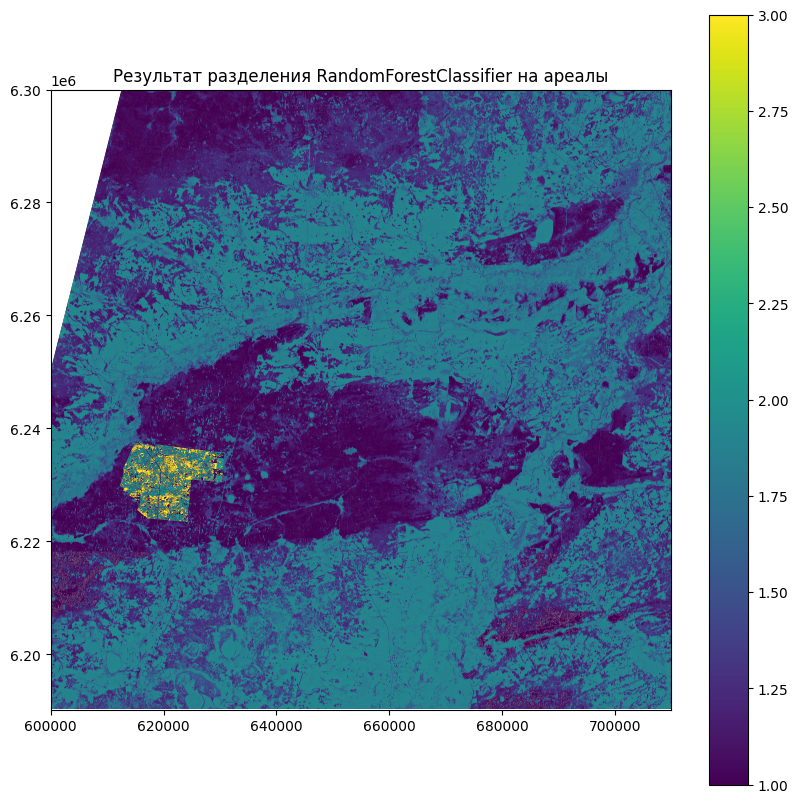

In [144]:
fig, ax = plt.subplots(figsize=(10, 10))

rf_labels = best_model.predict(X)
with rasterio.open('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_B03_10m.tif') as src:
    show(src, ax=ax)
    etalons.to_crs(src.crs).plot(ax=ax, column=rf_labels, legend=True)
    ax.set_title('Результат разделения RandomForestClassifier на ареалы')

# 2. Оценка фитомассы верхнего полога древостоя по разносезонным снимкам ДЗЗ, выявление аномалии или деградации лесов

### Алгоритм для выявления аномалии или деградации лесов на основе оценки фитомассы верхнего полога древостоя: <br>
```NDVI = ((NIR - Red)/(NIR + Red))```<br>
```NIR``` – значения пикселов из ближнего инфракрасного канала.<br>
```Red``` – значения пикселов из красного канала.<br>
Этот индекс принимает значения в диапазоне -1.0 и 1.0. Для растительности значение
индекса меняется от 0 до 1.0. 

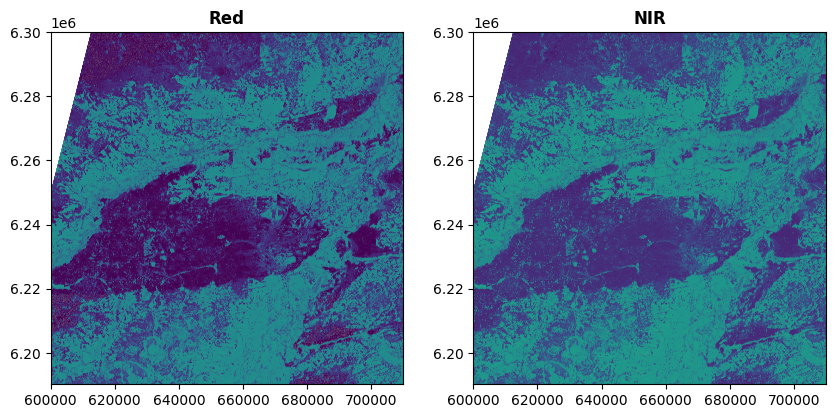

In [206]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

band4 = rasterio.open('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_B04_10m.tif')
show(band4, ax=ax1, title='Red');

band8 = rasterio.open('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_B08_10m.tif')
show(band8, ax=ax2, title='NIR');

### Для каждого пиксела (квадрат 10м х 10м) на карте определим индекс NDVI.

Два канала имеют разные размерности, поэтому перепроецируем канал NIR к размеру и геопривязке канала Red.

In [203]:
red = band4.read(1)

# Создаем массив для перепроецированного канала NIR
nir = np.empty(red.shape, dtype=red.dtype)

# Перепроецируем канал NIR к размеру и геопривязке канала Red
reproject(
    source=rasterio.band(band8, 1),
    destination=nir,
    src_transform=band8.transform,
    src_crs=band8.crs,
    dst_transform=band4.transform,
    dst_crs=band4.crs,
    resampling=ResamplingEnum.bilinear  # Явно указываем Resampling
);

Расчитываем NDVI и сохраняем в формате tiff.

In [204]:
# Масштабируем данные
nir = nir / nir.max()
red = red / red.max()

ndvi = np.where(
    (nir + red) == 0,
    0,
    (nir - red) / (nir + red)
)

with rasterio.open('../images/ndvi.tiff', 'w', driver='Gtiff',
         width=band4.width, height=band4.height,
         count=1, crs=band4.crs, transform=band4.transform, dtype='float64') as src:
    src.write(ndvi, 1)

C:\Users\319\AppData\Local\Temp\ipykernel_18252\3050381632.py:8: RuntimeWarning: invalid value encountered in divide
  (nir - red) / (nir + red)


### Визуализируем значение индекса NDVI в границах указанного участка леса:
- До деградации: Лес густой, с высоким уровнем фотосинтеза, и NDVI имеет высокие значения
(например, от 0.6 до 0.9).
- Во время деградации: В случае пожара или вырубки значительная часть растительности
исчезает, и NDVI падает (например, до 0.2–0.3).
- После деградации: Если лес не восстанавливается, а территория остается в деградированном
состоянии (например, заброшенные поля, кустарники), NDVI может оставаться на низком
уровне (около 0.1–0.3) и не демонстрировать больших сезонных колебаний.

Отрисуем график, где более высокий уровень ndvi соответстует зеленому цвету, а более низкий - желтому, красным цветом отобразится наихудший уровень (0<).

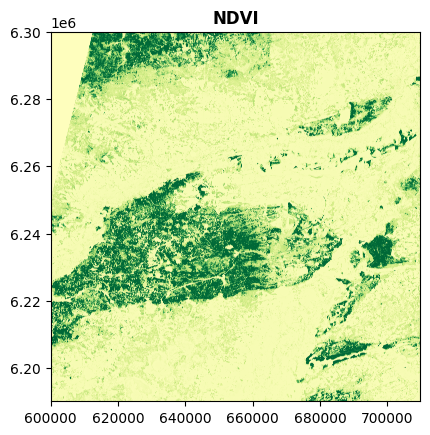

In [205]:
with rasterio.open('../images/ndvi.tiff') as src:
    im = show(src, cmap='RdYlGn', vmin=-1, vmax=1, title='NDVI')
    plt.show()

### Вывод

Лес имеет как густые части с высоким уровнем фотосинтентеза, так и деградирующие части, отмечаенные желтым цветом. Полей в асболютном деградированном состоянии не обнаружено.

# 3. Определение депрессивных зон леса в летние периоды – пожароопасные зоны


### Алгоритм для выявления депрессивных зон леса в летние периоды – пожароопасные
участки (используя спектральный индекс NDMI):<br>
```NDMI = (NIR - SWIR) / (NIR + SWIR)```<br>
```NIR``` – ближний инфракрасный диапазон<br>
```SWIR``` – коротковолновый инфракрасный
диапазон.<br>


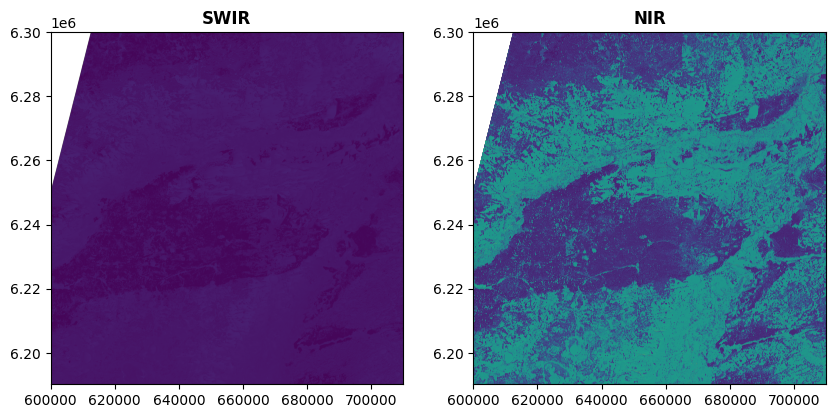

In [209]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

band12 = rasterio.open('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_B12_20m.tif')
show(band12, ax=ax1, title='SWIR');

band8 = rasterio.open('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_B08_10m.tif')
show(band8, ax=ax2, title='NIR');

### Для каждого пиксела на карте определим индекс NDMI

Два канала имеют разные размерности, поэтому перепроецируем канал SWIR к размеру и геопривязке канала NIR.

In [213]:
nir = band8.read(1)

# Создаем массив для перепроецированного канала NIR
swir = np.empty(nir.shape, dtype=nir.dtype)

# Перепроецируем канал NIR к размеру и геопривязке канала Red
reproject(
    source=rasterio.band(band12, 1),
    destination=swir,
    src_transform=band12.transform,
    src_crs=band12.crs,
    dst_transform=band8.transform,
    dst_crs=band8.crs,
    resampling=ResamplingEnum.bilinear  # Явно указываем Resampling
);

Расчитываем NDMI и сохраняем в формате tiff.

In [214]:
# Масштабируем данные
nir = nir / nir.max()
swir = swir / swir.max()

ndvi = np.where(
    (nir + swir) == 0,
    0,
    (nir - swir) / (nir + swir)
)

with rasterio.open('../images/ndmi.tiff', 'w', driver='Gtiff',
         width=band4.width, height=band4.height,
         count=1, crs=band4.crs, transform=band4.transform, dtype='float64') as src:
    src.write(ndvi, 1)

C:\Users\319\AppData\Local\Temp\ipykernel_18252\2794279918.py:8: RuntimeWarning: invalid value encountered in divide
  (nir - swir) / (nir + swir)


### Определим зоны, где растения испытывают дефицит влаги – зоны повышенной пожароопасности. Рассчитайте площадь этих зон в динамике, за каждый год.
Зоны дефицита влаги – NDMI в
диапазоне 0 – 0.4.

In [234]:
water_deficit = np.where(((ndvi <= 0.4) & (ndvi != 0)), 1, 0)
water_deficit_proportion = water_deficit.sum() / (water_deficit.shape[1] * water_deficit.shape[0]) * 100 
print(f'Зоны, где растения испытывают дефицит влаги составляют {water_deficit_proportion:.2f}% от общей площади лесов.')

Зоны, где растения испытывают дефицит влаги составляют 1.44% от общей площади лесов.


### Визуализируем на карте пожароопасные зоны.

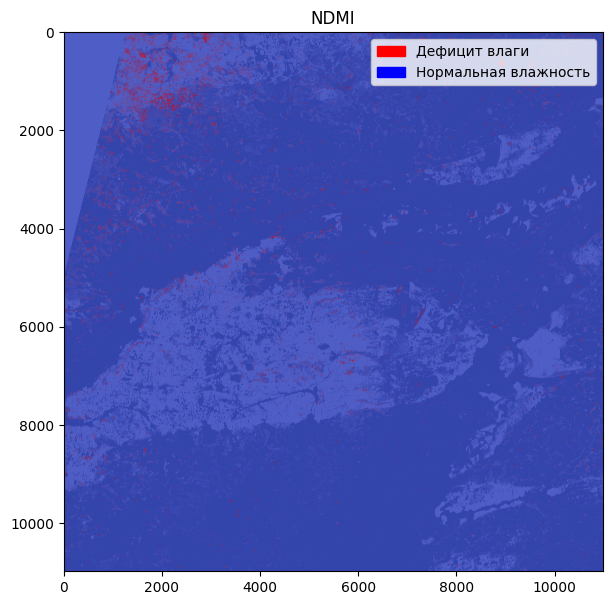

In [265]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

with rasterio.open('../images/673d62c1D36ebD4e58Da73bD2e6269da6532_B04e_10m.tif') as src:
    show(src.read(1), ax=ax, cmap='Greys')

ax.imshow(water_deficit, cmap='coolwarm', alpha=0.9)
ax.set_title('NDMI')
ax.legend(handles=[Patch(facecolor='red', edgecolor='red', label='Дефицит влаги'),
            Patch(facecolor='blue', edgecolor='blue', label='Нормальная влажность')]);

plt.show()

Алгоритм, вычисляющий NDMI отлично отработал и позволил нам найти зоны высокой пожароопасности.

Как видно из графика такие зоны есть и нужно обратить на них внимание, чтобы предотвратить лесные пожары.

Визуально оценим связь между индексами NDVI и NDMI в зонах пожароопасности. как видно из графиков высокая пожароопасность находится в местах с высоким индексом (NDMI), а это значит, что места плотной и здоровой растительности подвержены дефициту влаги.

# Отчет

В ходе выполнения модуля С было сделано следющее:
- Классифицированы типов лесов, найдена лучшая модель.
- Оценены NDVI.
- Оценены NDMI, пожароопасные зоны.
- Определена связь между индексами NDVI и NDMI в зонах пожароопасности.